# Compliance

Conformità della popolazione alle norme di igiene e sicurezza.

> Max Pierini

***

# Introduzione

In questa delicata fase, la maggior parte delle attività ha ripreso (o riprenderà presto) il consuento ritmo e la popolazione è libera di circolare sul territorio nazionale e, in parte, internazionale.

I contenimento quindi dell'epidemia dipende in gran parte, in assenza di un vaccino, dalla conformità della popolazione alle norme di igiene e sicurezza imposte dal Ministero della Salute.

Come sta rispondendo l'Italia? Gli italiani si attengono alle norme?

YouGov e l'Imperial College pubblicano regolarmente i risultati di un utile sondaggio internazionale sull'analisi del comportamento in fase pandemica, aggiornato con cadenza settimanale ([YouGov](https://github.com/YouGov-Data/covid-19-tracker)).

In [1]:
from copy import deepcopy
import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from IPython.display import display, Markdown, Latex

In [2]:
nomimal_columns = [
    "i12_health_1",   # Worn mask outside
    "i12_health_2",   # Washed hands
    "i12_health_3",   # Used hand sanitiser
    "i12_health_4",   # Covered your nose and mouth when sneezing or coughing
    "i12_health_5",   # Avoided contact with people who have symptoms
    "i12_health_6",   # Avoided going out in general
    "i12_health_7",   # Avoided going to hospital or other
    "i12_health_8",   # Avoided taking public transport
    "i12_health_9",   # Avoided working outside your home
    "i12_health_10",  # Avoided letting your children go to school
    "i12_health_11",  # Avoided having guests to your home
    "i12_health_12",  # Avoided small social gatherings
    "i12_health_13",  # Avoided medium-sized social gatherings
    "i12_health_14",  # Avoided large-sized social gatherings
    "i12_health_15",  # Avoided crowded areas
    "i12_health_16",  # Avoided going to shops
    "i12_health_17",  # Slept in separate bedrooms
    "i12_health_18",  # Eaten separately at home
    "i12_health_19",  # Cleaned frequently touched surfaces
    "i12_health_20",  # Avoided touching objects in public
]

baselines = {
    # Common behaviours
    "i12_health_2":  2,  # Washed hands
    "i12_health_3":  2,  # Used hand sanitiser
    "i12_health_4":  2,  # Covered your nose and mouth when sneezing or coughing
    "i12_health_5":  2,  # Avoided contact with people who have symptoms
    "i12_health_8":  2,  # Avoided taking public transport
    # Specific behaviours
    "i12_health_1":  0,  # Worn mask outside
    "i12_health_6":  0,  # Avoided going out in general
    "i12_health_7":  0,  # Avoided going to hospital or other
    "i12_health_9":  0,  # Avoided working outside your home
    "i12_health_11": 0,  # Avoided having guests to your home
    "i12_health_12": 0,  # Avoided small social gatherings
    "i12_health_13": 0,  # Avoided medium-sized social gatherings
    "i12_health_14": 0,  # Avoided large-sized social gatherings
    "i12_health_15": 0,  # Avoided crowded areas
    "i12_health_16": 0,  # Avoided going to shops
    "i12_health_17": 0,  # Slept in separate bedrooms
    "i12_health_18": 0,  # Eaten separately at home
    "i12_health_19": 0,  # Cleaned frequently touched surfaces
    "i12_health_20": 0,  # Avoided touching objects in public
}

nomimal_columns_dict = {
    "i12_health_1": "Indossare la mascherina all'esterno",
    "i12_health_2": "Lavarsi frequentemente le mani",
    "i12_health_3": "Usare gel igienizzanti",
    "i12_health_4": "Coprirsi naso e bocca se starnuti o tosse",
    "i12_health_5": "Evitare contatti con persone sintomatiche",
    "i12_health_6": "Evitare di uscire di casa in generale",
    "i12_health_7": "Evitare di andare in ospedali e ambulatori",
    "i12_health_8": "Evitare di usare i trasporti pubblici",
    "i12_health_9": "Evitare di lavorare fuori casa",
    "i12_health_10": "Evitare ai figli di andare a scuole e corsi",
    "i12_health_11": "Evitare di avere ospiti a casa",
    "i12_health_12": "Evitare piccoli assembramenti",
    "i12_health_13": "Evitare medi assembramenti",
    "i12_health_14": "Evitare grandi assembramenti",
    "i12_health_15": "Evitare zone affollate",
    "i12_health_16": "Evitare di frequentare negozi",
    "i12_health_17": "Dormire in stanze separate",
    "i12_health_18": "Mangiare in aree diverse in casa",
    "i12_health_19": "Pulire spesso le superfici toccate",
    "i12_health_20": "Evitare di toccare oggetti in pubblico",
}

# NOT TO BE IMPLEMENTED YET
value_colums = [
    "i13_health",  # how many times, would you say you washed your hands
]

nominal_to_value = {
    "Not at all":  0,  # Worst behaviour
    "Rarely" :    .25,
    "Sometimes":  .5,
    "Frequently": .75,
    "Always":      1,  # Best behaviour
}

valori_ita = ["Mai", "Raramente", "Qualche volta", "Spesso", "Sempre"]

region_ita = {
    "Centre": "Centro",
    "Islands": "Isole",
    "North east": "Nord Est",
    "North west": "Nord Ovest",
    "South": "Sud",
}

zone_regioni = {
"North west": ["Aosta","Liguria","Lombardy","Piedmont"],
"North east": ["Emilia-Romagna","Friuli-Venezia_Giulia","Trento","Bolzano","Veneto"],
"Centre": ["Lazio","Marche","Tuscany","Umbria"],
"South": ["Abruzzo","Apulia","Basilicata","Calabria","Campania","Molise"],
"Islands": ["Sardinia","Sicily"],
}

In [3]:
colums_to_use = deepcopy(nomimal_columns)
colums_to_use.append("qweek")
colums_to_use.append("region")
colums_to_use.append("endtime")

data = pd.read_csv(
    "https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/italy.csv",
    usecols=colums_to_use,
    index_col=["endtime", "qweek", "region"],
    encoding="ISO-8859-1")

In [4]:
data['datetime'] = pd.to_datetime(
    data.index.get_level_values('endtime'), 
    format="%d/%m/%Y %H:%M")

In [5]:
data.reset_index(level='endtime', inplace=True)
data.set_index('datetime', 'qweek', 'region', inplace=True)

In [6]:
for nominal in nominal_to_value:
    data.replace(nominal, nominal_to_value[nominal], inplace=True)

In [7]:
data.replace(' ', 0, inplace=True)

In [8]:
Qweek = {}
qweeks = data.index.get_level_values('qweek').unique()
for qweek in qweeks:
    mean_date = data.loc[qweek,:,:].index.get_level_values('datetime').unique().mean()
    Qweek.update({qweek: mean_date.date()})

# Metodo

In [9]:
display(Markdown(f"""
I dati sono stati (finora) raccolti nell'arco di {qweeks.size} settimane 
a partire dal 2 Aprile 2020 e sono suddivisi 
per zone geografiche: Nord Est, Nord Ovest, Centro, Sud e Isole.
"""))


I dati sono stati (finora) raccolti nell'arco di 14 settimane 
a partire dal 2 Aprile 2020 e sono suddivisi 
per zone geografiche: Nord Est, Nord Ovest, Centro, Sud e Isole.


In [10]:
for zona in zone_regioni:
    regioni = "\n- ".join(zone_regioni[zona])
    subjects = data.loc[data.index.get_level_values("region")==zona].shape[0]
    print(f"{region_ita[zona]} (soggetti: {subjects})")
    print(f"- {regioni}")
    print()

Nord Ovest (soggetti: 3762)
- Aosta
- Liguria
- Lombardy
- Piedmont

Nord Est (soggetti: 2698)
- Emilia-Romagna
- Friuli-Venezia_Giulia
- Trento
- Bolzano
- Veneto

Centro (soggetti: 2799)
- Lazio
- Marche
- Tuscany
- Umbria

Sud (soggetti: 3255)
- Abruzzo
- Apulia
- Basilicata
- Calabria
- Campania
- Molise

Isole (soggetti: 1523)
- Sardinia
- Sicily



In [11]:
lista = "\n- ".join(list(nomimal_columns_dict.values()))
display(Markdown(f"""
Analizzeremo i seguenti risultati:

- {lista}
"""))


Analizzeremo i seguenti risultati:

- Indossare la mascherina all'esterno
- Lavarsi frequentemente le mani
- Usare gel igienizzanti
- Coprirsi naso e bocca se starnuti o tosse
- Evitare contatti con persone sintomatiche
- Evitare di uscire di casa in generale
- Evitare di andare in ospedali e ambulatori
- Evitare di usare i trasporti pubblici
- Evitare di lavorare fuori casa
- Evitare ai figli di andare a scuole e corsi
- Evitare di avere ospiti a casa
- Evitare piccoli assembramenti
- Evitare medi assembramenti
- Evitare grandi assembramenti
- Evitare zone affollate
- Evitare di frequentare negozi
- Dormire in stanze separate
- Mangiare in aree diverse in casa
- Pulire spesso le superfici toccate
- Evitare di toccare oggetti in pubblico


In [12]:
giorni = "\n- ".join(f"{w.replace('week', 'settimana')} = {Qweek[w]}" for w in Qweek)

display(Markdown(f"""
Per ciascuna settimana, i sondaggi sono stati effettuati nell'arco di circa 3 giorni.
Pertanto sceglieremo il giorno medio come indicativo:

- {giorni}
"""))


Per ciascuna settimana, i sondaggi sono stati effettuati nell'arco di circa 3 giorni.
Pertanto sceglieremo il giorno medio come indicativo:

- settimana 1 = 2020-04-03
- settimana 2 = 2020-04-08
- settimana 3 = 2020-04-16
- settimana 4 = 2020-04-25
- settimana 5 = 2020-05-01
- settimana 6 = 2020-05-07
- settimana 7 = 2020-05-14
- settimana 8 = 2020-05-28
- settimana 9 = 2020-06-10
- settimana 10 = 2020-06-25
- settimana 11 = 2020-07-09
- settimana 12 = 2020-07-23
- settimana 13 = 2020-08-07
- settimana 14 = 2020-08-20


In [13]:
risposte = "\n- ".join(f"{nominal_to_value[n]:.2f} = {valori_ita[i]}" for i, n in enumerate(nominal_to_value))

display(Markdown(f"""
Le risposte sono di tipo nominale, assegneremo perciò un valore
numerico da 0 a 1, dal comportamento meno conforme (Mai) al più conforme (Sempre)

- {risposte}
"""))


Le risposte sono di tipo nominale, assegneremo perciò un valore
numerico da 0 a 1, dal comportamento meno conforme (Mai) al più conforme (Sempre)

- 0.00 = Mai
- 0.25 = Raramente
- 0.50 = Qualche volta
- 0.75 = Spesso
- 1.00 = Sempre


# Risultati

## Zone

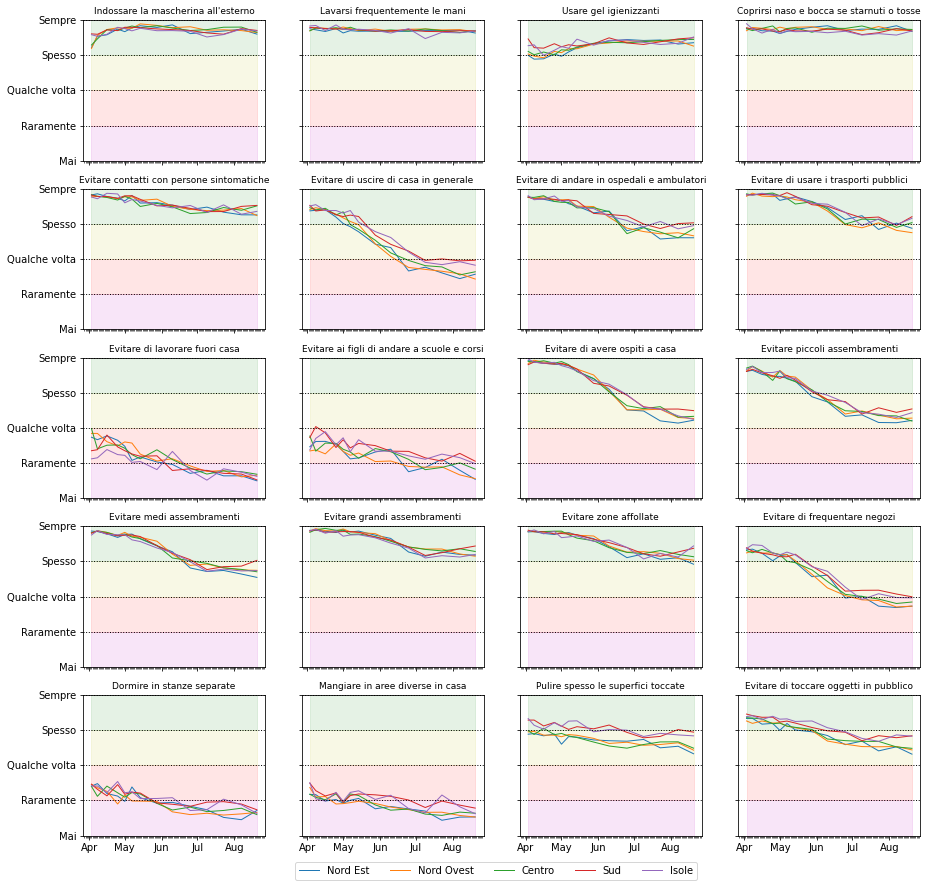

In [14]:
zones = ["North east", "North west", "Centre", "South", "Islands"]

fig, ax = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)

display_data = {}
for zone in zones:
    display_data.update({zone: {}})
    for nomimal_column in nomimal_columns:
        display_data[zone].update({nomimal_column: []})

i = 0
for nomimal_column in nomimal_columns:
    weeks = []
    #print(f"------> {nomimal_column}")
    #display_data.update({nomimal_column: []})
    for idx in data.index.get_level_values('qweek').unique():
        j = 0
        weeks.append(Qweek[idx])
        for zone in zones:
            week_data = data.loc[idx,zone,:][nomimal_column]
            display_data[zone][nomimal_column].append(week_data.mean())
    for zone in zones:
        #print(f"------> {zone}")
        #print(weeks)
        #print(display_data[zone][nomimal_column])
        ax.flat[i].plot(
            weeks, display_data[zone][nomimal_column],
            lw=1, label=region_ita[zone]
        )
        j += 1
    ax.flat[i].set_title(nomimal_columns_dict[nomimal_column], fontsize=9)
    for x in list(nominal_to_value.values()):
        ax.flat[i].axhline(x, c="k", ls=":", lw=1)
        
    ax.flat[i].fill_between(weeks, 0, .25, color='m', alpha=.1)
    ax.flat[i].fill_between(weeks, .25, .5, color='r', alpha=.1)
    ax.flat[i].fill_between(weeks, .5, .75, color='y', alpha=.1)
    ax.flat[i].fill_between(weeks, .75, 1, color='g', alpha=.1)
    
    i += 1

ax.flat[i-2].legend(loc="lower right", ncol=5, bbox_to_anchor=(1, -.35))
ax[0,0].set_ylim(0, 1)
ax[0,0].set_yticks(list(nominal_to_value.values()))
ax[0,0].set_yticklabels(valori_ita)
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0,0].xaxis.set_minor_locator(mdates.DayLocator())

#plt.subplots_adjust(bottom=0.15)
fig.set_facecolor('w')
plt.show();

Non essendoci differenze significative tra i risultati delle zone (tranne che per "Pulire spesso le superifici toccate" più frequente al Sud e sulle Isole), useremo la media nazionale dei valori, confrontando la differenza percentuale tra la prima settimana e l'ultima.

## Italia

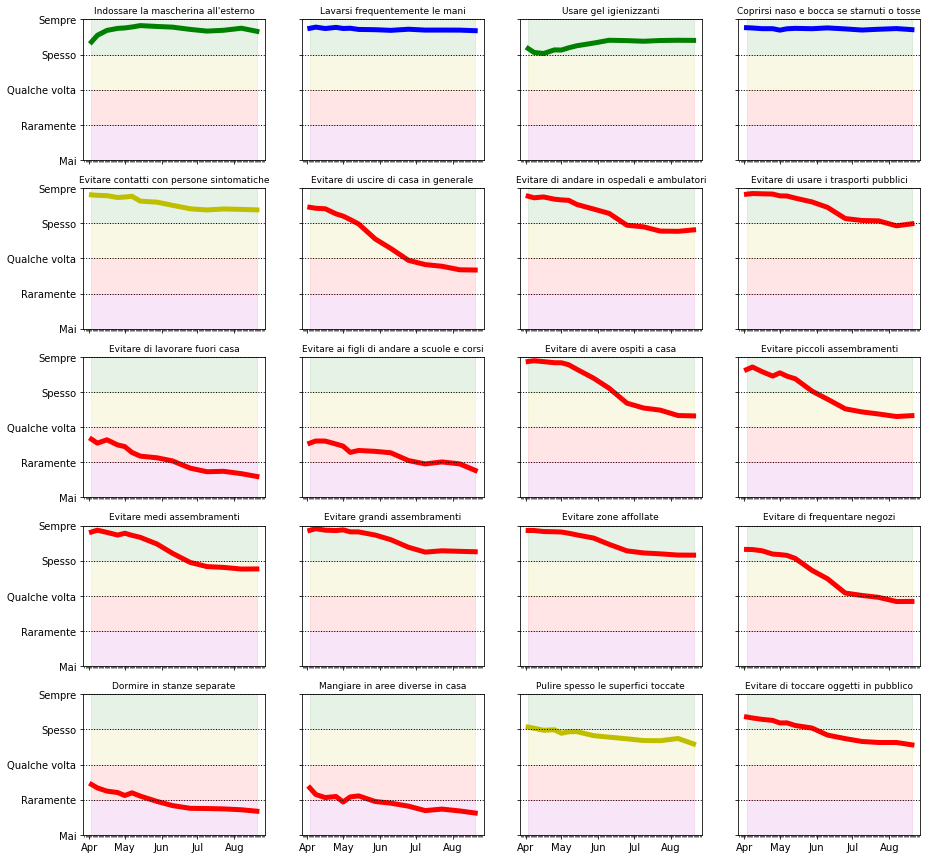

In [15]:
fig, ax = plt.subplots(5, 4, figsize=(15, 15), sharex=True, sharey=True)

display_data = {}

i = 0
for nomimal_column in nomimal_columns:
    weeks = []
    display_data.update({nomimal_column: []})
    for idx in data.index.get_level_values('qweek').unique():
        weeks.append(Qweek[idx])
        display_data[nomimal_column].append(data.loc[idx,:,:][nomimal_column].mean())
    diff = display_data[nomimal_column][-1] - display_data[nomimal_column][0]
    if diff < -.15:
        c="r"
    elif diff < -.05:
        c="y"
    elif diff > 0:
        c="g"
    else:
        c="b"
    ax.flat[i].plot(
        weeks, np.array(display_data[nomimal_column]),
        c=c, lw=5
    )
    ax.flat[i].set_title(nomimal_columns_dict[nomimal_column], fontsize=9)
    for x in list(nominal_to_value.values()):
        ax.flat[i].axhline(x, c="k", ls=":", lw=1)
    
    ax.flat[i].fill_between(weeks, 0, .25, color='m', alpha=.1)
    ax.flat[i].fill_between(weeks, .25, .5, color='r', alpha=.1)
    ax.flat[i].fill_between(weeks, .5, .75, color='y', alpha=.1)
    ax.flat[i].fill_between(weeks, .75, 1, color='g', alpha=.1)
    
    i += 1

ax[0,0].set_ylim(0, 1)
ax[0,0].set_yticks(list(nominal_to_value.values()))
ax[0,0].set_yticklabels(valori_ita)
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0,0].xaxis.set_minor_locator(mdates.DayLocator())

fig.set_facecolor('w')
plt.show();

## Variazioni

Variazioni percentuali dal primo giorno di raccolta dati:

In [16]:
diffs = {}

for nomimal_column in nomimal_columns:
    diff = display_data[nomimal_column][-1] - display_data[nomimal_column][0]
    diffs.update({diff: nomimal_columns_dict[nomimal_column]})

for d, v in sorted(diffs.items(), reverse=True):
    print(f"{d:>7.2%}  {v}")

  7.55%  Indossare la mascherina all'esterno
  5.79%  Usare gel igienizzanti
 -1.38%  Coprirsi naso e bocca se starnuti o tosse
 -1.70%  Lavarsi frequentemente le mani
-10.70%  Evitare contatti con persone sintomatiche
-11.99%  Pulire spesso le superfici toccate
-15.24%  Evitare grandi assembramenti
-17.56%  Evitare zone affollate
-17.92%  Mangiare in aree diverse in casa
-19.05%  Dormire in stanze separate
-19.41%  Evitare ai figli di andare a scuole e corsi
-19.84%  Evitare di toccare oggetti in pubblico
-21.02%  Evitare di usare i trasporti pubblici
-23.96%  Evitare di andare in ospedali e ambulatori
-26.26%  Evitare medi assembramenti
-26.49%  Evitare di lavorare fuori casa
-32.72%  Evitare piccoli assembramenti
-37.01%  Evitare di frequentare negozi
-38.67%  Evitare di avere ospiti a casa
-44.63%  Evitare di uscire di casa in generale


In [17]:
display(Markdown(f"""

Sono in aumento:
"""))

for d, v in sorted(diffs.items(), reverse=True):
    if d > 0:
        print(f"{d:>7.2%}  {v}")

display(Markdown(f"""
Sono quasi staazionari:
"""))

for d, v in sorted(diffs.items(), reverse=True):
    if d < 0 and d > -.05:
        print(f"{d:>7.2%}  {v}")

display(Markdown(f"""        
Sono in calo:
"""))

for d, v in sorted(diffs.items(), reverse=True):
    if d < -.05:
        print(f"{d:>7.2%}  {v}")



Sono in aumento:


  7.55%  Indossare la mascherina all'esterno
  5.79%  Usare gel igienizzanti



Sono quasi staazionari:


 -1.38%  Coprirsi naso e bocca se starnuti o tosse
 -1.70%  Lavarsi frequentemente le mani


        
Sono in calo:


-10.70%  Evitare contatti con persone sintomatiche
-11.99%  Pulire spesso le superfici toccate
-15.24%  Evitare grandi assembramenti
-17.56%  Evitare zone affollate
-17.92%  Mangiare in aree diverse in casa
-19.05%  Dormire in stanze separate
-19.41%  Evitare ai figli di andare a scuole e corsi
-19.84%  Evitare di toccare oggetti in pubblico
-21.02%  Evitare di usare i trasporti pubblici
-23.96%  Evitare di andare in ospedali e ambulatori
-26.26%  Evitare medi assembramenti
-26.49%  Evitare di lavorare fuori casa
-32.72%  Evitare piccoli assembramenti
-37.01%  Evitare di frequentare negozi
-38.67%  Evitare di avere ospiti a casa
-44.63%  Evitare di uscire di casa in generale


In [18]:
display(Markdown(f"""

In particolare:"""))

for d, v in sorted(diffs.items(), reverse=True):
    if d < -.15:
        print(f"{d:>7.2%}  {v}")

display(Markdown(f"""sono notevolmente in calo (superiore al 15%)."""))



In particolare:

-15.24%  Evitare grandi assembramenti
-17.56%  Evitare zone affollate
-17.92%  Mangiare in aree diverse in casa
-19.05%  Dormire in stanze separate
-19.41%  Evitare ai figli di andare a scuole e corsi
-19.84%  Evitare di toccare oggetti in pubblico
-21.02%  Evitare di usare i trasporti pubblici
-23.96%  Evitare di andare in ospedali e ambulatori
-26.26%  Evitare medi assembramenti
-26.49%  Evitare di lavorare fuori casa
-32.72%  Evitare piccoli assembramenti
-37.01%  Evitare di frequentare negozi
-38.67%  Evitare di avere ospiti a casa
-44.63%  Evitare di uscire di casa in generale


sono notevolmente in calo (superiore al 15%).

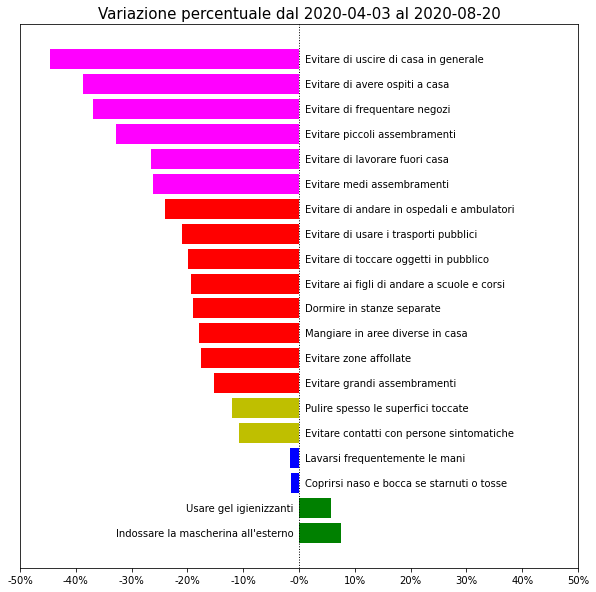

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

x = 0
for d, v in sorted(diffs.items(), reverse=True):
    if d > 0:
        c = "g"
    elif d < -.25:
        c = "magenta"
    elif d < -.15:
        c = "r"
    elif d < -.05:
        c = "y"
    elif d < 0:
        c = "b"
    ax.barh(
        x, d,
        label=v, color=c
    )
    _y = -.01
    ha = "right"
    if d < 0:
        _y = .01
        ha = "left"
    ax.text(_y, x, v, ha=ha, va="center")
    x += 1

xmin = np.array(list(diffs.keys())).min()*1.05
xmin_round = np.round(xmin, decimals=1)
ax.set_xlim(xmin, -xmin)
ax.set_yticks([])
ax.set_xticks(np.arange(xmin_round, -xmin_round+.1, .1))
ax.set_xticklabels([f"{p:.0%}" for p in np.arange(xmin_round, -xmin_round+.1, .1)])
ax.axvline(0, c="k", ls=":", lw=1)

ax.set_title(f"Variazione percentuale dal {Qweek['week 1']} al {Qweek[list(Qweek.keys())[-1]]}", fontsize=15)
plt.show();

## Ultimi dati

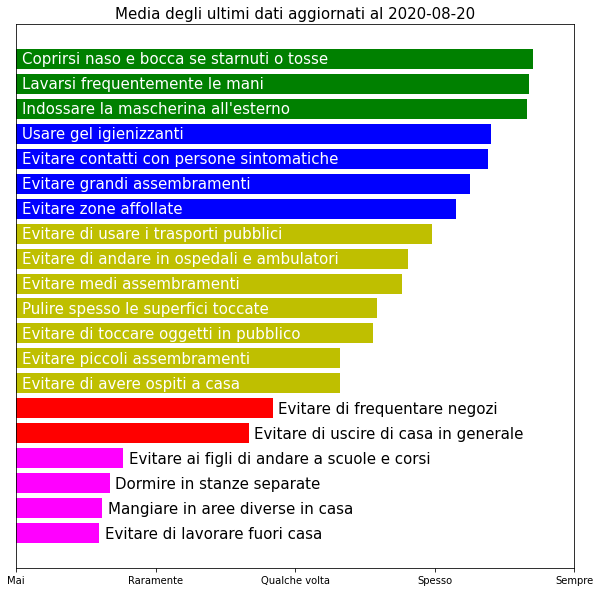

In [20]:
latest = {}
for param in display_data:
    latest.update({display_data[param][-1]: nomimal_columns_dict[param]})


x = 0
fig, ax = plt.subplots(figsize=(10,10))
for p, v in sorted(latest.items()):
    if p > .9:
        c = "g"
    elif p > .75:
        c = "b"
    elif p > .5:
        c = "y"
    elif p > .25:
        c = "r"
    else:
        c = "magenta"
    ax.barh(
        x, p,
        color=c
    )
    _y = .01
    c = "w"
    if p < .5:
        _y = p + .01
        c = "k"
    ax.text(_y, x, v, va="center", ha="left", c=c, fontsize=15)
    x += 1

ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xticks(list(nominal_to_value.values()))
ax.set_xticklabels(valori_ita)

ax.set_title(f"Media degli ultimi dati aggiornati al {Qweek[list(Qweek.keys())[-1]]}", fontsize=15)
plt.show();

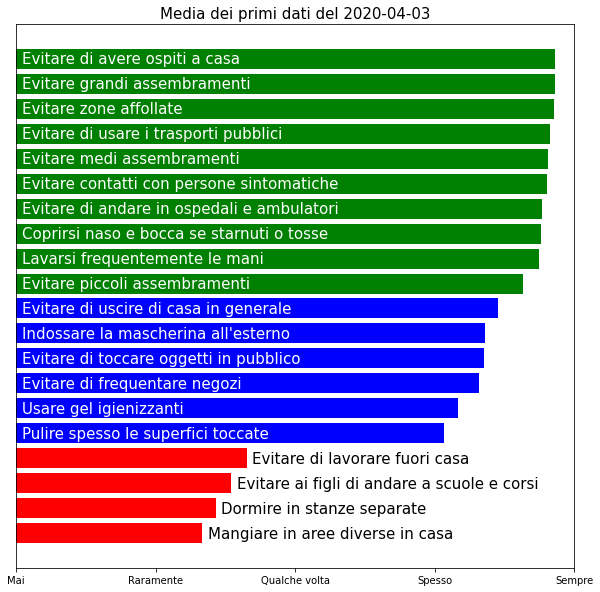

In [21]:
first = {}
for param in display_data:
    first.update({display_data[param][0]: nomimal_columns_dict[param]})


x = 0
fig, ax = plt.subplots(figsize=(10,10))
for p, v in sorted(first.items()):
    if p > .9:
        c = "g"
    elif p > .75:
        c = "b"
    elif p > .5:
        c = "y"
    elif p > .25:
        c = "r"
    else:
        c = "magenta"
    ax.barh(
        x, p,
        color=c
    )
    _y = .01
    c = "w"
    if p < .5:
        _y = p + .01
        c = "k"
    ax.text(_y, x, v, va="center", ha="left", c=c, fontsize=15)
    x += 1

ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xticks(list(nominal_to_value.values()))
ax.set_xticklabels(valori_ita)

ax.set_title(f"Media dei primi dati del {Qweek['week 1']}", fontsize=15)
plt.show();